In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
    
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical

In [2]:
df = pd.read_csv("../heart.csv", header=0)
print(df
      )
df['age'] = df['age'].astype(float)
print(df.dtypes)

      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0      52    1   0       125   212    0        1      168      0      1.0   
1      53    1   0       140   203    1        0      155      1      3.1   
2      70    1   0       145   174    0        1      125      1      2.6   
3      61    1   0       148   203    0        1      161      0      0.0   
4      62    0   0       138   294    1        1      106      0      1.9   
...   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
1020   59    1   1       140   221    0        1      164      1      0.0   
1021   60    1   0       125   258    0        0      141      1      2.8   
1022   47    1   0       110   275    0        0      118      1      1.0   
1023   50    0   0       110   254    0        0      159      0      0.0   
1024   54    1   0       120   188    0        1      113      0      1.4   

      slope  ca  thal  target  
0         2   2     3       0  
1         0

In [3]:
 
def class_distribution(df, id_to_label, figsize=(16,6)):
 
    labels = df.iloc[:, -1]
    class_counts = labels.value_counts().sort_index()
    class_names = [id_to_label[i] for i in class_counts.index]

    plt.figure(figsize=figsize)
    bars = plt.bar(class_names, class_counts.values, color='salmon', edgecolor='darkred')

    plt.title("Distribution of Heartbeat Classes")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=20, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    total = len(labels)
    for bar, count in zip(bars, class_counts.values):
        pct = (count / total) * 100
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total*0.01,
                 f"{count} ({pct:.1f}%)",
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.show()

In [4]:
def build_cnn_lstm(input_shape, num_classes):
    """
    Build a hybrid CNN-LSTM model for ECG classification.

    Parameters
    ----------
    input_shape : tuple
        Shape of input data (timesteps, features). For ECG: (188, 1).
    num_classes : int
        Number of output classes.

    Returns
    -------
    model : tf.keras.Model
        Compiled CNN-LSTM model.
    """
    inputs = layers.Input(shape=input_shape)

    # CNN block
    x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(inputs)   
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # LSTM block
    x = layers.LSTM(64, return_sequences=False)(x)

    # Fully connected
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

timesteps = X.shape[1]
print("Detected timesteps:", timesteps)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = X_scaled.reshape(X_scaled.shape[0], timesteps, 1)

num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes=num_classes)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_cat, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)

Detected timesteps: 13
Train shape: (820, 13, 1) (820, 2)
Validation shape: (205, 13, 1) (205, 2)


In [6]:
def build_cnn_lstm(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [7]:
model = build_cnn_lstm(input_shape=(timesteps, 1), num_classes=num_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 13, 64)            384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 128)            41088     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 128)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 64)                49408 

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5
26/26 [==============================] - 7s 33ms/step - loss: 0.6092 - accuracy: 0.6976 - val_loss: 0.4767 - val_accuracy: 0.7805
Epoch 2/5
26/26 [==============================] - 0s 9ms/step - loss: 0.4427 - accuracy: 0.8073 - val_loss: 0.3786 - val_accuracy: 0.8293
Epoch 3/5
26/26 [==============================] - 0s 9ms/step - loss: 0.3740 - accuracy: 0.8415 - val_loss: 0.3530 - val_accuracy: 0.8439
Epoch 4/5
26/26 [==============================] - 0s 9ms/step - loss: 0.3014 - accuracy: 0.8768 - val_loss: 0.3599 - val_accuracy: 0.8488
Epoch 5/5
26/26 [==============================] - 0s 9ms/step - loss: 0.2769 - accuracy: 0.8939 - val_loss: 0.2836 - val_accuracy: 0.8976


In [ ]:
loss, acc = model.evaluate(X_val, y_val)
print(f"Test A  ccuracy: {acc:.4f}, Test Loss: {loss:.4f}")

7/7 [==============================] - 0s 4ms/step - loss: 0.2836 - accuracy: 0.8976
Test Accuracy: 0.8976, Test Loss: 0.2836


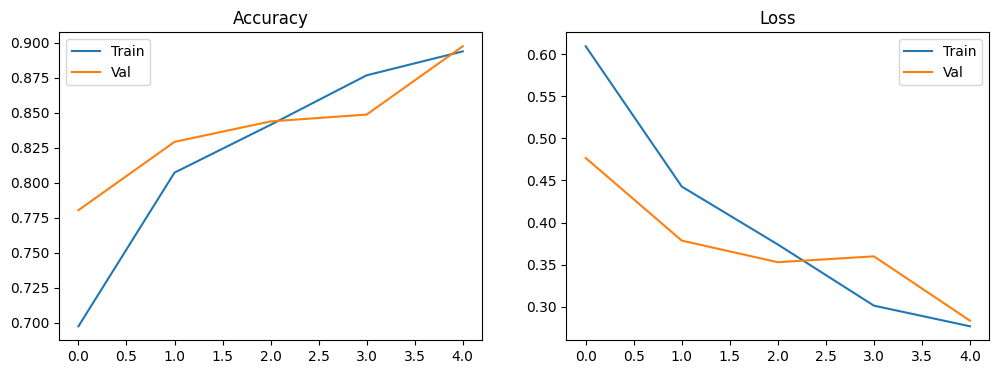

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()

In [11]:
model.save("ecg_cnn_lstm_model.h5")